In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

These changes are implemented in the new architecture: GNNSAGERecommenderwithSkipConnections.  
Internally instead of using the regular GNN, uses the GNNSAGE

# Imports

In [2]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import GNNSAGERecommenderwithSkipConnections
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "mean"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [8]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:-1].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

/tmp/ipykernel_31467/2748178780.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.066554048230569' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:-1].mean()
/tmp/ipykernel_31467/2748178780.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.36317032389292053' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:-1].mean()
/tmp/ipykernel_31467/2748178780.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1562.9824694465033' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  additional_test_users.iloc[:, 1:-1] = train_user_df.iloc

In [9]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [10]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [11]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [12]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [13]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [14]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [15]:
# Instantiate the model
model = GNNSAGERecommenderwithSkipConnections(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [16]:
# move the model 
model.to(device)

GNNSAGERecommenderwithSkipConnections(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): SAGEConv(64, 64, aggr=mean)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): Linear(in_features=64, out_features=1, bias=True)
)

# Add hook 

This will help track the outputs

In [17]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [18]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 5.2285, Val Loss: 5.1555, best model epoch: 100
Epoch: 200, Train Loss: 2.1637, Val Loss: 2.1565, best model epoch: 200
Epoch: 300, Train Loss: 0.9179, Val Loss: 0.9123, best model epoch: 296
Epoch: 400, Train Loss: 0.4172, Val Loss: 0.4049, best model epoch: 384
Epoch: 500, Train Loss: 0.1439, Val Loss: 0.1708, best model epoch: 494
Epoch: 600, Train Loss: 0.1119, Val Loss: 0.1208, best model epoch: 597
Epoch: 700, Train Loss: 0.1118, Val Loss: 0.1537, best model epoch: 688
Epoch: 800, Train Loss: 0.1000, Val Loss: 0.1153, best model epoch: 777
Epoch: 900, Train Loss: 0.0864, Val Loss: 0.1564, best model epoch: 891
Epoch: 1000, Train Loss: 0.0830, Val Loss: 0.0816, best model epoch: 999


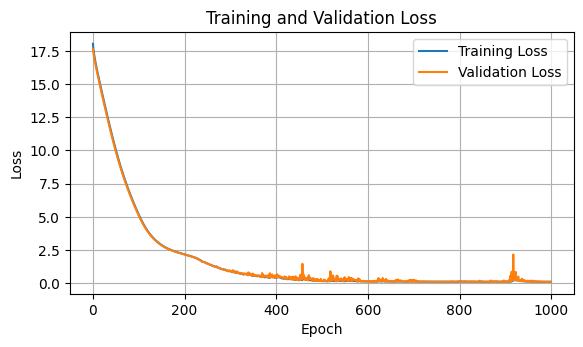

In [19]:
plot_train_val_loss(train_loss, test_loss)

# Test

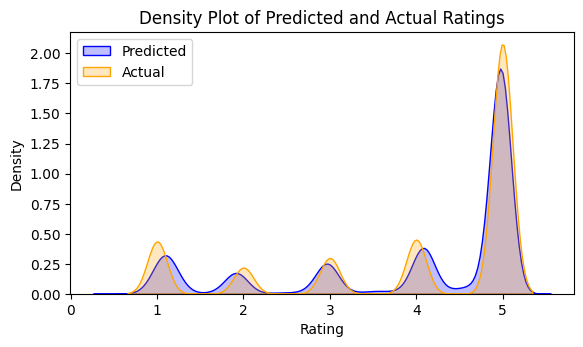

Test loss: 0.0809


In [20]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Recomendations 

In [21]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [22]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Remington MicroScreen SF-3 Electric Cordless Shaver
Product 2: Philips Norelco Electric Razor Shaver, Model 6705X
Product 3: Philips Sonicare Essence+ Gum Health & Airfloss Rechargeable Electric Flosser, Bundle Value Pack, HX8218/02
Product 4: Colgate 360 Floss-Tip Electric (Battery) 2 Toothbrush w/ 4 Replacement Heads Bundle
Product 5: HQRP Battery for Philips Sonicare HX6711 HX6712 HX6730 HX6731 HX6732 HX6780 HX6781 HX6782 HX9342 HX6733 HX6750 HX6511 HX6530 HX6581 HX6582 HealthyWhite Toothbrush Repair + HQRP Coaster
Product 6: Toothbrush Case, eJiasu Toothbrush Holder Travel (Purple)
Product 7: Philips Sonicare HX3351/02 Xtreme Battery Operated Toothbrush
Product 8: Philips Sonicare HX3351/02 Xtreme Battery Operated Toothbrush
Product 9: Professional Dental Electric Tooth Polisher - Cordless Stain & Calculus Remover For Tooth Whitening - Orange Flavored Medium Grit Tooth Polish
Product 10: Hydroblast Pro Cordless Water Flosser
tensor([3.9487, 3.9427, 3.9411, 3.9400, 3.9380

In [23]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [24]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Alphabet Island Phonics Complete Set (I & 2)
Product 2: BIEN ETRE EAU ESSENCES FRAICHES 500 ML
Product 3: Hallmark 3 Film Collection (Harvest Love/Pumpkin Pie Wars/Truly Madly Sweetly)
Product 4: The Great Gatsby by F. Scott Fitzgerald (1995) Paperback
Product 5: Parfumée des Familles Tendresse d'Enfance 250 ml'
Product 6: H42 Clipper Cleaner 16 Oz. Jar Virucidal Anti-bacterial by H-42
Product 7: 0
Product 8: Lot of 10 Avon Moisture Therapy Intensive Healing & Repair Hand Cream Extra Dry Skin 4.2 Fl Oz. Fragrance Free
Product 9: KEUNE 1922 by J.M. Keune Classic Gel, 5.1 Fl oz
Product 10: Oklahoma Game Rangers' Cookbook
tensor([5.1248, 5.1248, 5.1243, 5.1211, 5.1200, 5.1187, 5.1172, 5.1172, 5.1168,
        5.1161], device='cuda:0')


In [25]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [26]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Oklahoma Game Rangers' Cookbook
Product 2: Alphabet Island Phonics Complete Set (I & 2)
Product 3: Alaska Fishing: DVD & Ultimate Guide! Lake Creek King Salmon Float Trip
Product 4: 0
Product 5: Oral-B 8860 DLX Professional Care Oral Care System
Product 6: Philips HP-4829/00
Product 7: Dinesh D'Souza Collection + Digital Copy (2016: Obama's America/America - Imagine The World Without Her/Hillary's America)
Product 8: ABC Book of Shadows (hc) by Katie Olivares
Product 9: The World of Cross Stitching Magazine Number 197 (Forever Friends)
Product 10: Inspector Morse Colin Dexter 13 Books Complete Collection Set


In [27]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [ ]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

user_df[user_df.user_id == user_id]

Product 1: Remington MicroScreen SF-3 Electric Cordless Shaver
Product 2: Philips Norelco Electric Razor Shaver, Model 6705X
Product 3: Philips Sonicare Essence+ Gum Health & Airfloss Rechargeable Electric Flosser, Bundle Value Pack, HX8218/02
Product 4: Colgate 360 Floss-Tip Electric (Battery) 2 Toothbrush w/ 4 Replacement Heads Bundle
Product 5: HQRP Battery for Philips Sonicare HX6711 HX6712 HX6730 HX6731 HX6732 HX6780 HX6781 HX6782 HX9342 HX6733 HX6750 HX6511 HX6530 HX6581 HX6582 HealthyWhite Toothbrush Repair + HQRP Coaster
Product 6: Toothbrush Case, eJiasu Toothbrush Holder Travel (Purple)
Product 7: Philips Sonicare HX3351/02 Xtreme Battery Operated Toothbrush
Product 8: Philips Sonicare HX3351/02 Xtreme Battery Operated Toothbrush
Product 9: Professional Dental Electric Tooth Polisher - Cordless Stain & Calculus Remover For Tooth Whitening - Orange Flavored Medium Grit Tooth Polish
Product 10: Hydroblast Pro Cordless Water Flosser
tensor([3.9487, 3.9427, 3.9411, 3.9400, 3.9380

,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,embedding
37895,AFLI33M7ADMQ2B3DSIJLODWUHTAA,4.002339,1.066554,1.251847,0.36317,0.894689,1562.982469,1583.650489,41.737485,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Analysing predictions

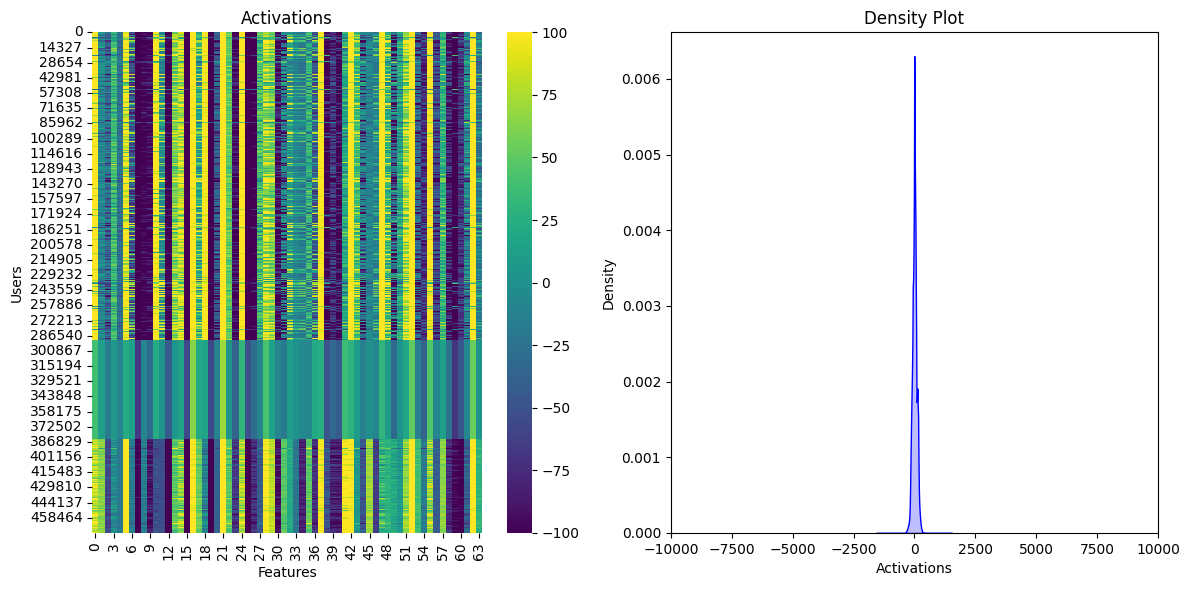

In [ ]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

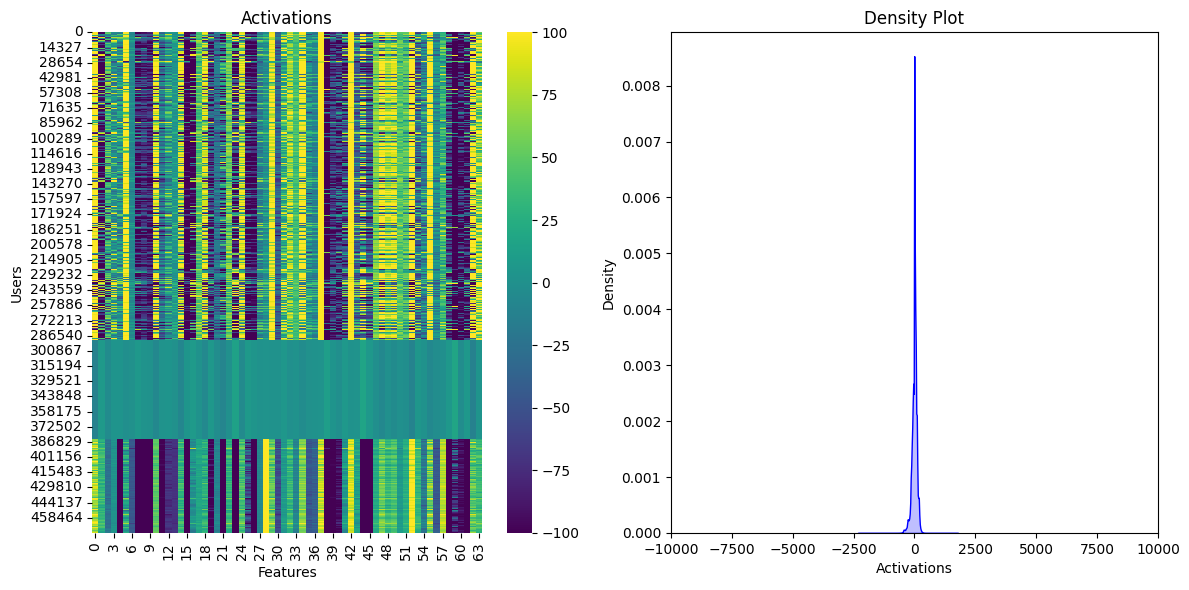

In [ ]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

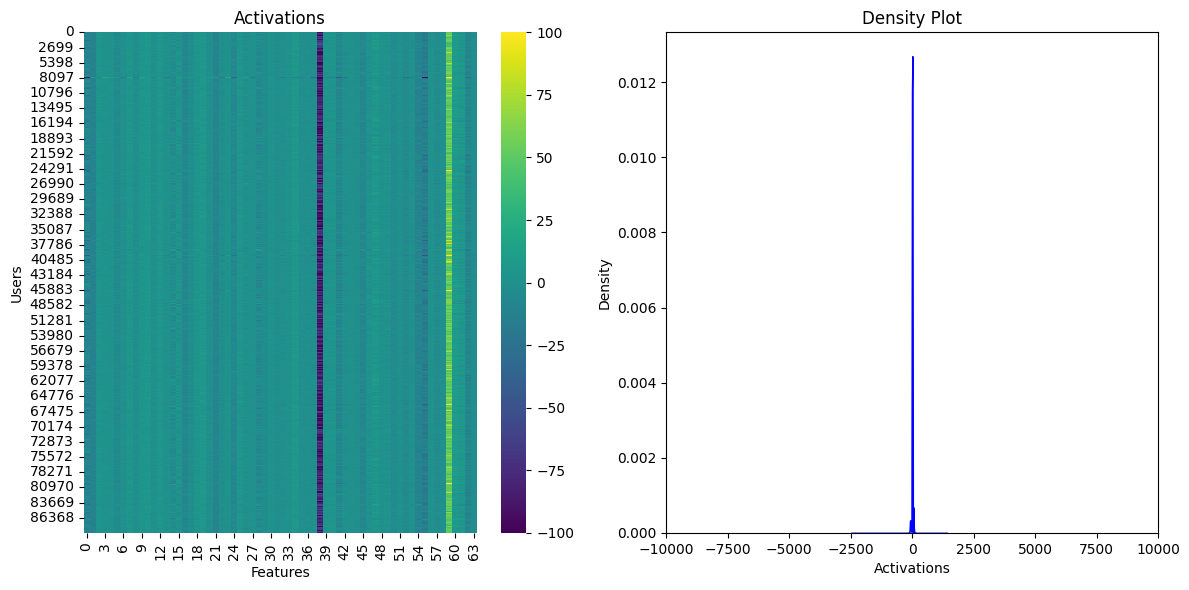

In [ ]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

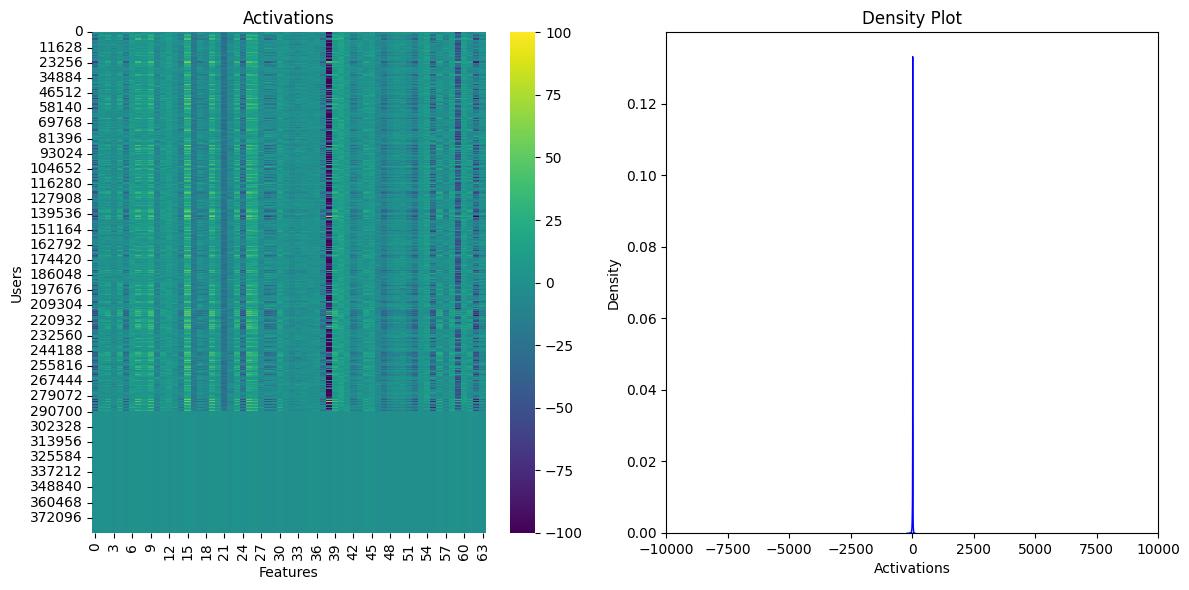

In [ ]:
# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

# Metrics

In [ ]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [ ]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [ ]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [ ]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [ ]:
preds = set(y.item() for x in test_edges_grp.prediction for y in x)
len(preds)

520